### Agent-Lab: Multi-Agent -> Voice Assistant

Objective of this notebook is evaluating and adapting a [Multi-Agent Supervisor Architecture](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) with coordinator and execution planning steps.

---


In [1]:
%%capture
import json
import os
import nest_asyncio
from IPython.display import Markdown, display, Audio
from dotenv import load_dotenv
from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

os.chdir("..")
load_dotenv()
nest_asyncio.apply()

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

---
### Upload Audio Attachment

In [2]:
# create attachment
file_path = "tests/integration/voice_memos_01_pt_BR.mp3"
attachment_id = experiment_utils.create_attachment(
    file_path=file_path, content_type="audio/mp3"
)
display(Audio(file_path))

---
### OpenAI Voice Assistant

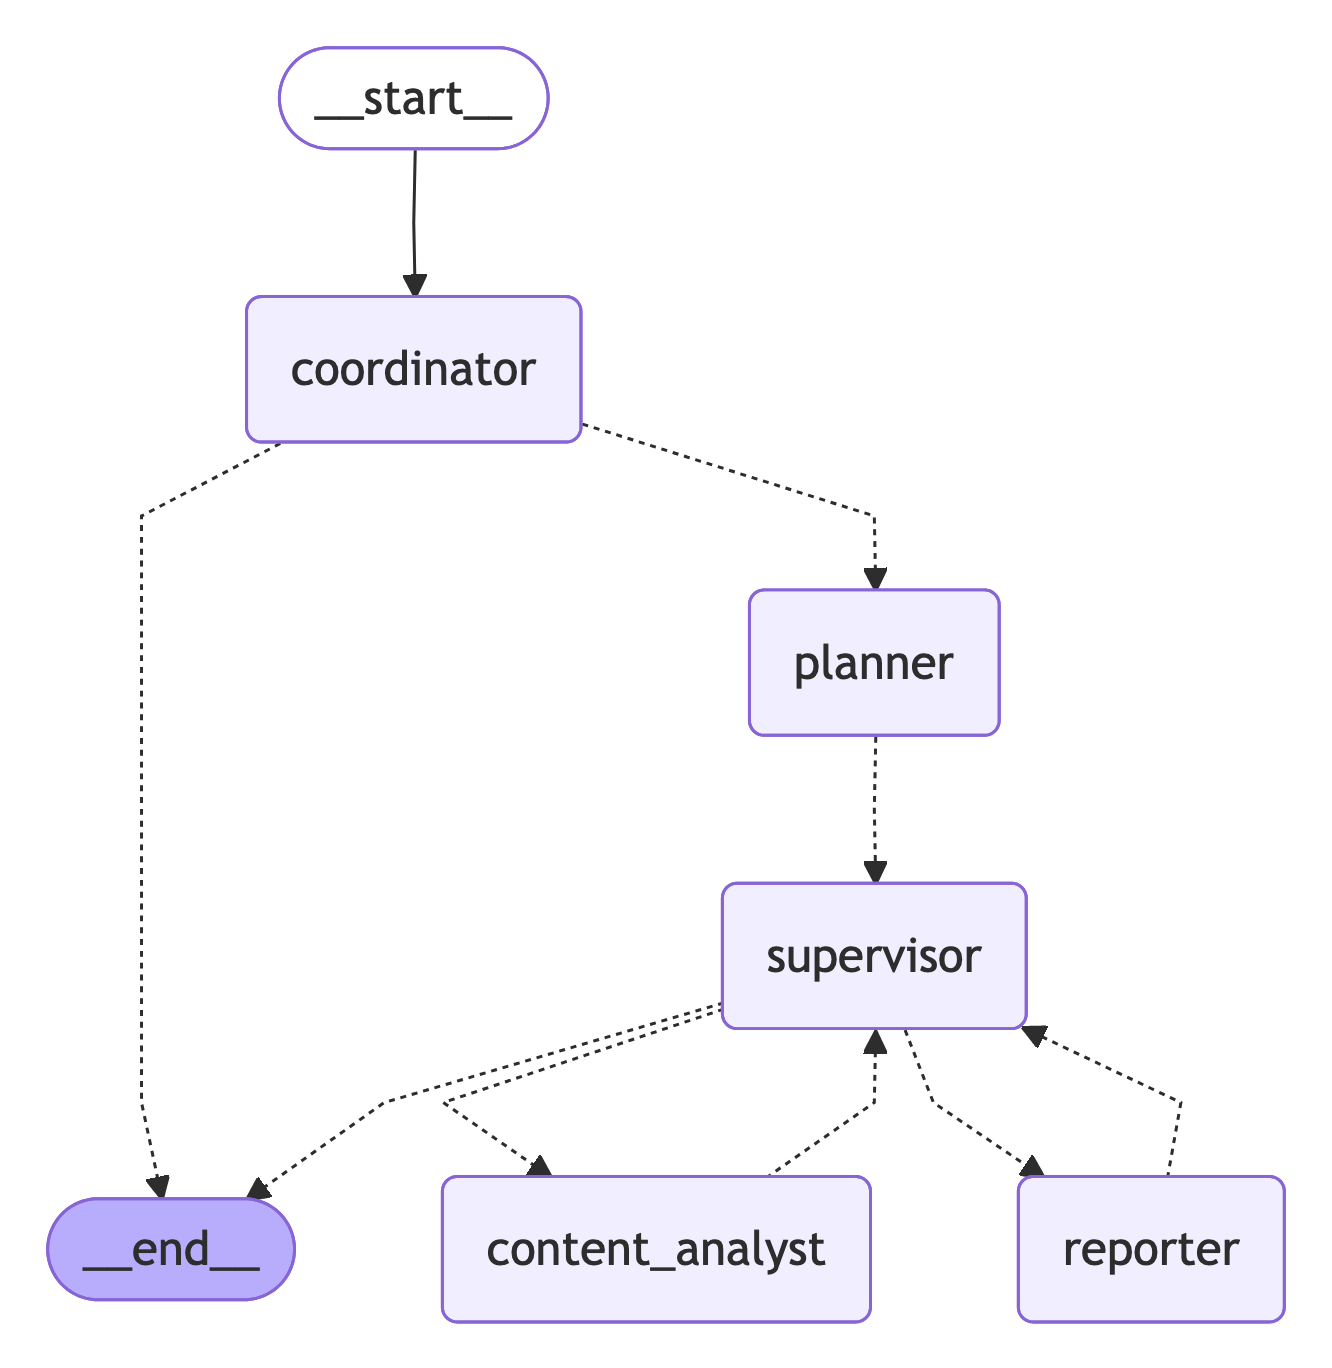

In [3]:
# Create Workflow
openai_agent = experiment_utils.create_openai_agent(
    agent_type="voice_memos", llm_tag="gpt-5-nano", api_key=os.getenv("OPENAI_API_KEY")
)
openai_voice_assistant = container.voice_memos_agent()
openai_workflow_builder = openai_voice_assistant.get_workflow_builder(openai_agent["id"])
openai_workflow = openai_workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(openai_workflow)

In [7]:
%%capture

message = MessageRequest(
    message_role="human",
    message_content="Analyse the given audio.",
    agent_id=openai_agent["id"],
    attachment_id=attachment_id,
)

inputs = openai_voice_assistant.get_input_params(message, schema="public")
config = openai_voice_assistant.get_config(openai_agent["id"])
result = openai_workflow.invoke(inputs, config)
ai_message_content, workflow_state = openai_voice_assistant.format_response(result)

In [8]:
display(
    Markdown(
        f"**Execution Plan:**\n```json\n{json.dumps(workflow_state.get("execution_plan"), indent=2)}\n```"
    )
)

**Execution Plan:**
```json
{
  "thought": "Foi relatado que houve uma reuni\u00e3o hoje \u00e0s 11h com Aline, da equipe de marketing, sobre o desenvolvimento do Projeto Agente X. Ela informou que o projeto est\u00e1 atrasado e que \u00e9 necess\u00e1rio acelerar o desenvolvimento. Al\u00e9m disso, a Aline mencionou que a equipe de vendas est\u00e1 preocupada com o prazo de entrega e que \u00e9 essencial apresentar uma atualiza\u00e7\u00e3o na pr\u00f3xima reuni\u00e3o, que ocorrer\u00e1 na semana que vem.",
  "title": "An\u00e1lise de \u00e1udio: Reuni\u00e3o sobre o Projeto Agente X",
  "steps": [
    {
      "agent_name": "content_analyst",
      "title": "An\u00e1lise contextual do \u00e1udio e extra\u00e7\u00e3o de informa\u00e7\u00f5es-chave",
      "description": "Repita a transcri\u00e7\u00e3o em palavras pr\u00f3prias (thought). Em seguida, produza um relat\u00f3rio Markdown com os achados-chave: participantes (Aline da equipe de marketing), hora (hoje \u00e0s 11h), assunto (desenvolvimento do Projeto Agente X), status (atrasado), a\u00e7\u00e3o requerida (acelerar o desenvolvimento), preocupa\u00e7\u00f5es da equipe de vendas quanto ao prazo, necessidade de apresentar atualiza\u00e7\u00e3o na pr\u00f3xima reuni\u00e3o (na pr\u00f3xima semana). Sa\u00eddas esperadas: relat\u00f3rio Markdown com os achados e perguntas para valida\u00e7\u00e3o."
    },
    {
      "agent_name": "reporter",
      "title": "Preparar sa\u00edda final em JSON",
      "description": "Formatar o relat\u00f3rio final em JSON para o usu\u00e1rio, incluindo resumo dos fatos, informa\u00e7\u00f5es-chave, impactos no cronograma, a\u00e7\u00f5es recomendadas, pr\u00f3ximos passos e responsabilidades sugeridas."
    }
  ]
}
```

In [9]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}"))

**AI Message Content:**

- Main Topic
  - Reunião sobre o desenvolvimento do Projeto Agente X, com atraso identificado e necessidade de acelerar o andamento; atualização a ser apresentada na próxima reunião (na semana que vem).

- Discussed points
  - Reunião realizada hoje às 11h com Aline, da equipe de marketing.
  - Projeto Agente X está atrasado; necessidade de acelerar o desenvolvimento.
  - Equipe de vendas está preocupada com o prazo de entrega.
  - É essencial apresentar uma atualização na próxima reunião, que ocorrerá na próxima semana.

- Decisions taken
  - Acelerar o desenvolvimento do Projeto Agente X.
  - Apresentar uma atualização sobre o andamento do projeto na próxima reunião (na semana que vem).

- Next steps
  - Preparar e estruturar a atualização para a próxima reunião.
  - Alinhar com as equipes de marketing, desenvolvimento e vendas para obter status atual e estimativas revisadas.
  - Identificar bloqueios que estejam atrapalhando o ritmo de desenvolvimento e buscar soluções rápidas.

- Action points
  - Aline (Marketing): fornecer status do progresso e estimativas de aceleração; preparar pontos-chave para a atualização.
  - Equipe de desenvolvimento/projeto Agente X: detalhar tarefas críticas, prazos revisados e blockers a serem resolvidos.
  - Equipe de Vendas: trazer confirmação de compromissos de entrega e impactos no calendário.
  - Coordenação entre equipes para compor a atualização final a ser apresentada na próxima reunião.

- Named entities
  - Aline — Equipe de Marketing (Marketing Team)
  - Projeto Agente X — Projeto em desenvolvimento
  - Equipe de Marketing
  - Equipe de Vendas